In [1]:
import findspark
findspark.init()
from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row,SQLContext
import sys
import requests

import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# create spark configuration
conf = SparkConf()
conf.setAppName("TwitterStreamApp")
# create spark instance with the above configuration
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
# creat the Streaming Context from the above spark context with window size 2 seconds
ssc = StreamingContext(sc, 30)
# setting a checkpoint to allow RDD recovery
ssc.checkpoint("checkpoint_TwitterApp")
# read data from port 9009
dataStream = ssc.socketTextStream("localhost",9009)

In [3]:
def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']


def process_rdd(time, rdd):
    print("----------- %s -----------" % str(time))
    try:
        sql_context = get_sql_context_instance(rdd.context)
        row_rdd = rdd.map(lambda w: Row(hashtag=w[0].encode("latin2").decode("latin2"), hashtag_count=w[1])) # creating rows for one rdd

        hashtags_df = sql_context.createDataFrame(row_rdd)
        hashtags_df.createOrReplaceTempView("hashtags")  # temp view to use sql commands on it
        
        hashtag_counts_df = sql_context.sql("select hashtag, hashtag_count from hashtags order by hashtag_count desc, hashtag limit 10")
        hashtag_counts_df.show()  # table of top hashtags
                
        df_plot = hashtag_counts_df.toPandas()
        #display.clear_output(wait=True)   # I won't clear it to see the whole history
        plt.figure( figsize = ( 10, 8 ) )
        ax = sns.barplot( x="hashtag_count", y="hashtag", data=df_plot)
        ax.set(xlabel='Number of occurrences', ylabel='Hashtag', title="Most popular hashtags on Twitter")
        plt.show()
        
        
    except:
        e = sys.exc_info()[0]
        print("Error: %s" % e)

        
def filter_tags(tag):
    if tag.startswith('#'):      # skipping some incomplete tags after decoding in latin2
        if (tag != "#") & (tag != "#_") & (tag != "#__"): 
            return True
        else:
            return False
    else:
        return False

----------- 2020-05-18 11:59:30 -----------
+------------------+-------------+
|           hashtag|hashtag_count|
+------------------+-------------+
|             #hero|            1|
|     #herosplendor|            1|
|       #jackysat50|            1|
|#jackyselectronics|            1|
|        #jackysuae|            1|
|#justtheessentials|            1|
|#mujoogabasajjamwe|            1|
|    #ramadankareem|            1|
|    #ramadanoffers|            1|
|         #splendor|            1|
+------------------+-------------+



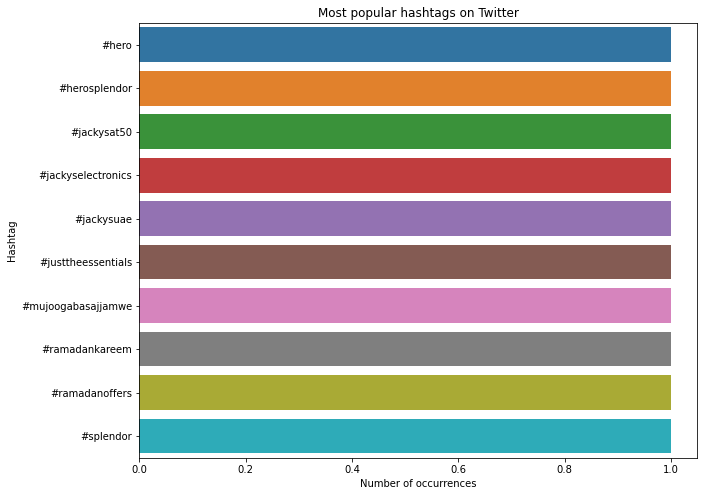

----------- 2020-05-18 12:00:00 -----------
+---------------+-------------+
|        hashtag|hashtag_count|
+---------------+-------------+
|   #coronavirus|            2|
|        #30in30|            1|
|#30in30movement|            1|
|           #ard|            1|
|  #centraltexas|            1|
|        #coffee|            1|
|  #coffeelovers|            1|
| #coffeemorning|            1|
|     #dailysoap|            1|
|     #destroyed|            1|
+---------------+-------------+



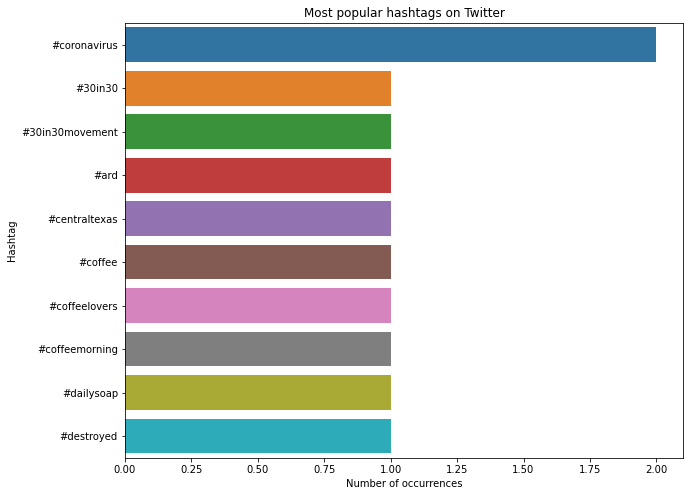

----------- 2020-05-18 12:00:30 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|             #hamont|            3|
|        #coronavirus|            2|
|         #felizlunes|            2|
|        #happymonday|            2|
|                  #1|            1|
|#1daytoqueenrosieday|            1|
|        #20mforcarry|            1|
|             #30in30|            1|
|     #30in30movement|            1|
|           #abudhabi|            1|
+--------------------+-------------+



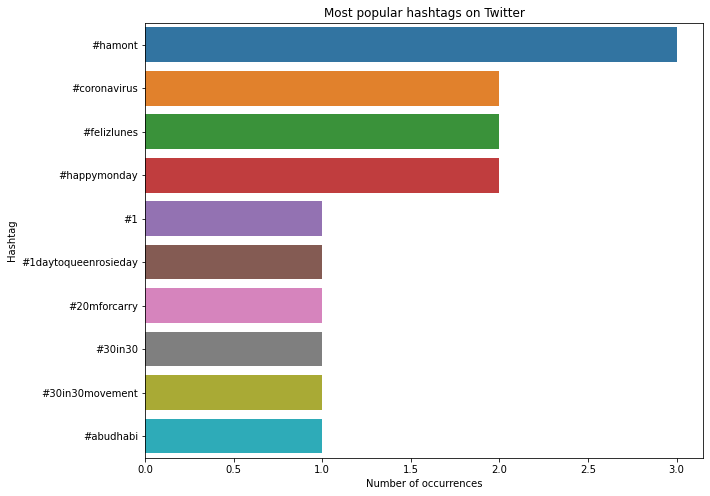

----------- 2020-05-18 12:01:00 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|        #coronavirus|            3|
|             #hamont|            3|
|         #felizlunes|            2|
|        #happymonday|            2|
|     #migrantworkers|            2|
|  #mujoogabasajjamwe|            2|
|           #stayhome|            2|
|                  #1|            1|
|#1daytoqueenrosieday|            1|
|        #20mforcarry|            1|
+--------------------+-------------+



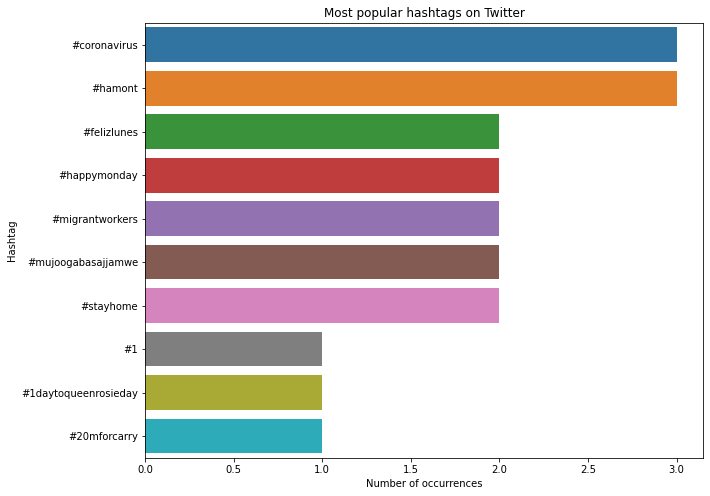

----------- 2020-05-18 12:01:30 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|        #coronavirus|            3|
|             #hamont|            3|
|  #mujoogabasajjamwe|            3|
|#newjerseyturnpik...|            3|
|         #felizlunes|            2|
|        #happymonday|            2|
|     #migrantworkers|            2|
|           #stayhome|            2|
|                #us9|            2|
|                  #1|            1|
+--------------------+-------------+



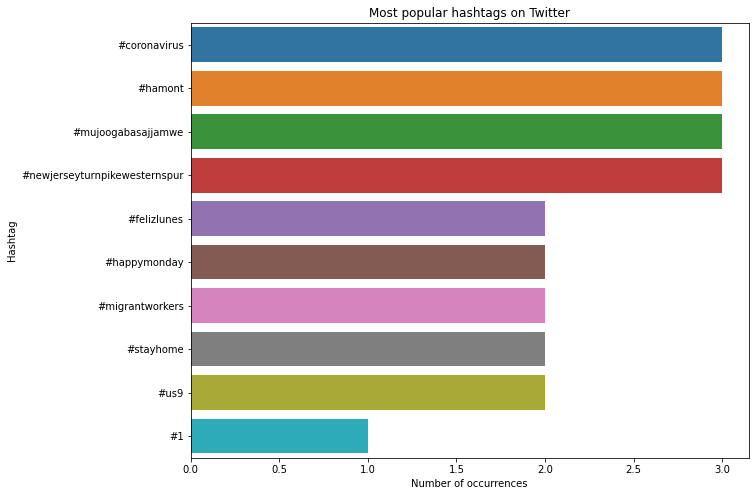

----------- 2020-05-18 12:02:00 -----------
+--------------------+-------------+
|             hashtag|hashtag_count|
+--------------------+-------------+
|               #us11|            6|
|               #ny49|            4|
|        #coronavirus|            3|
|             #hamont|            3|
|  #mujoogabasajjamwe|            3|
|#newjerseyturnpik...|            3|
|           #stayhome|            3|
|         #felizlunes|            2|
|        #happymonday|            2|
|                #i81|            2|
+--------------------+-------------+



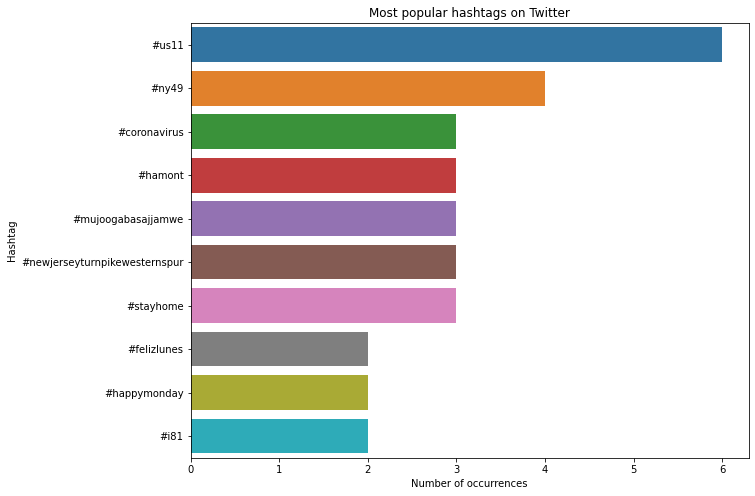

----------- 2020-05-18 12:02:30 -----------


In [ ]:
words = dataStream.flatMap(lambda line: line.split(" "))
hashtags = words.filter(lambda w: filter_tags(w)).map(lambda x: (x, 1))
tags_totals = hashtags.updateStateByKey(lambda x,y: sum(x) + (y or 0))  # adding new hashtag counts in each iteration
tags_totals.foreachRDD(process_rdd)  # processing all those tags to dataframe and plotting


ssc.start()
ssc.awaitTermination()